In [2]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.3/263.3 kB 7.8 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 27.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 26.2 MB/s eta 0:00:0000:0100:01
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
trace = pd.read_feather("./data_for_icwsm/icwsmtuned_random_invert_0_umap_clustered_35_trace.feather")

In [2]:
df = trace[["u_id","x","y","dt"]]
grid_size = 50
df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
df['y_grid'] = ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * (grid_size - 1)).astype(int)

# Sort by user and datetime to ensure correct transition order
df.sort_values(['u_id', 'dt'], inplace=True)

# Calculate transitions
df['from_x'] = df['x_grid'].shift(1)
df['from_y'] = df['y_grid'].shift(1)
df['to_x'] = df['x_grid']
df['to_y'] = df['y_grid']

# Filter out rows that do not represent a transition (first occurrence for each user)
transitions = df[df['u_id'] == df['u_id'].shift(1)]

# Count transitions
#transitions = df.groupby(['from_x', 'from_y', 'to_x', 'to_y']).size().reset_index(name='count')
transitions


/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_73606/33887795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)


,u_id,x,y,dt,x_grid,y_grid,from_x,from_y,to_x,to_y
0,12428,21.852156,-5.451804,2020-10-05 13:11:46+00:00,15,13,16.0,16.0,15,13
50405,12428,22.517124,-4.323751,2020-10-06 01:30:51+00:00,18,18,15.0,13.0,18,18
50406,12428,23.640362,-2.489461,2020-10-06 01:36:42+00:00,23,25,18.0,18.0,23,25
50408,29283,26.746895,-3.141624,2020-08-08 22:40:35+00:00,37,22,21.0,16.0,37,22
50409,29283,27.124683,-2.451145,2020-08-11 01:25:22+00:00,38,25,37.0,22.0,38,25
...,...,...,...,...,...,...,...,...,...,...
166283,1305305314875637761,25.819817,-3.943700,2020-10-01 16:28:29+00:00,32,19,34.0,18.0,32,19
166284,1305305314875637761,25.748693,-3.820274,2020-10-05 22:29:09+00:00,32,20,32.0,19.0,32,20
50402,1305305314875637761,25.460497,-3.798409,2020-10-10 13:07:36+00:00,31,20,32.0,20.0,31,20
50403,1305305314875637761,25.509678,-3.810917,2020-10-16 19:57:30+00:00,31,20,31.0,20.0,31,20


In [3]:
import numpy as np

# Calculate vector components, magnitudes, and angles
transitions['dx'] = transitions['to_x'] - transitions['from_x']
transitions['dy'] = transitions['to_y'] - transitions['from_y']
transitions['magnitude'] = np.sqrt(transitions['dx']**2 + transitions['dy']**2)
transitions['angle'] = np.arctan2(transitions['dy'], transitions['dx']) * 180 / np.pi

# Function to calculate vector mean and standard deviations
def vector_statistics(group):
    mean_dx = np.mean(group['dx'])
    mean_dy = np.mean(group['dy'])
    mean_magnitude = np.mean(group['magnitude'])
    mean_angle = np.mean(group['angle'])
    std_magnitude = np.std(group['magnitude'])
    std_angle = np.std(group['angle'])
    count = group.shape[0]
    return pd.Series({
        'mean_dx': mean_dx,
        'mean_dy': mean_dy,
        'mean_magnitude': mean_magnitude,
        'mean_angle': mean_angle,
        'std_magnitude': std_magnitude,
        'std_angle': std_angle,
        'count': count
    })

# Skipping for now, but available if necessary
# vector_stats = transitions.groupby(['from_x', 'from_y']).apply(vector_statistics).reset_index()


/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_73606/3702733179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['dx'] = transitions['to_x'] - transitions['from_x']
/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_73606/3702733179.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['dy'] = transitions['to_y'] - transitions['from_y']
/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_73606/3702733179.py:6: SettingWithCopyWarning: 
A value is trying to 

In [4]:
transitions

,u_id,x,y,dt,x_grid,y_grid,from_x,from_y,to_x,to_y,dx,dy,magnitude,angle
0,12428,21.852156,-5.451804,2020-10-05 13:11:46+00:00,15,13,16.0,16.0,15,13,-1.0,-3.0,3.162278,-108.434949
50405,12428,22.517124,-4.323751,2020-10-06 01:30:51+00:00,18,18,15.0,13.0,18,18,3.0,5.0,5.830952,59.036243
50406,12428,23.640362,-2.489461,2020-10-06 01:36:42+00:00,23,25,18.0,18.0,23,25,5.0,7.0,8.602325,54.462322
50408,29283,26.746895,-3.141624,2020-08-08 22:40:35+00:00,37,22,21.0,16.0,37,22,16.0,6.0,17.088007,20.556045
50409,29283,27.124683,-2.451145,2020-08-11 01:25:22+00:00,38,25,37.0,22.0,38,25,1.0,3.0,3.162278,71.565051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166283,1305305314875637761,25.819817,-3.943700,2020-10-01 16:28:29+00:00,32,19,34.0,18.0,32,19,-2.0,1.0,2.236068,153.434949
166284,1305305314875637761,25.748693,-3.820274,2020-10-05 22:29:09+00:00,32,20,32.0,19.0,32,20,0.0,1.0,1.000000,90.000000
50402,1305305314875637761,25.460497,-3.798409,2020-10-10 13:07:36+00:00,31,20,32.0,20.0,31,20,-1.0,0.0,1.000000,180.000000
50403,1305305314875637761,25.509678,-3.810917,2020-10-16 19:57:30+00:00,31,20,31.0,20.0,31,20,0.0,0.0,0.000000,0.000000


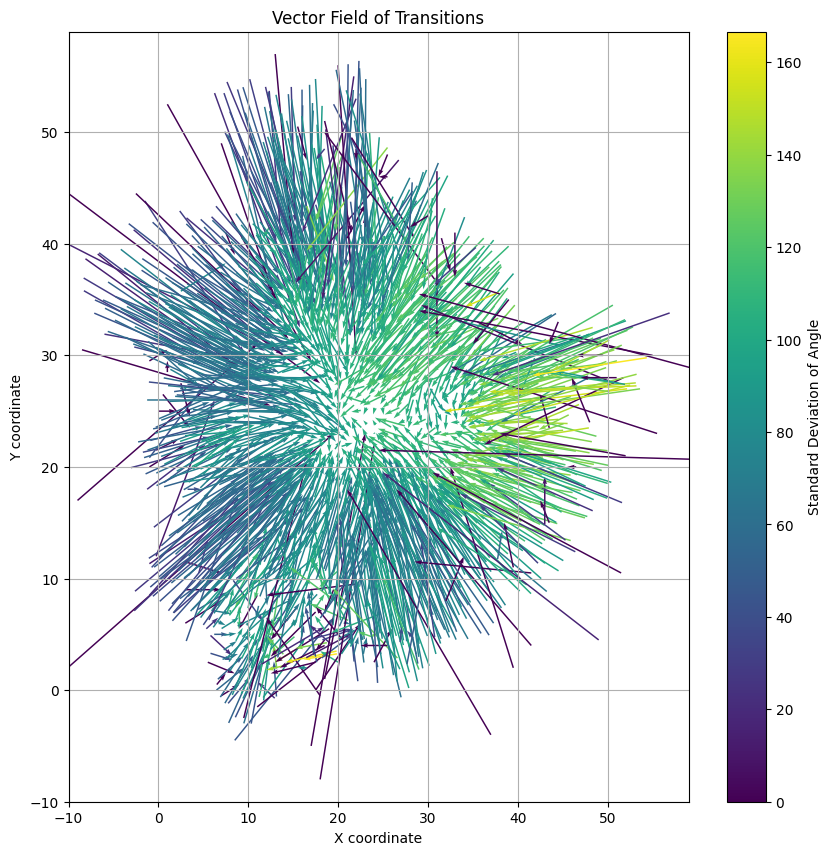

In [40]:
import matplotlib.pyplot as plt
import numpy as np
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
# Quiver plot
colors = ax.quiver(vector_stats['from_x'], vector_stats['from_y'], vector_stats['mean_dx'], vector_stats['mean_dy'],
                   vector_stats['std_angle'], angles='xy', scale_units='xy', scale=1, cmap='viridis', pivot='mid')

# Colorbar
cbar = fig.colorbar(colors, ax=ax)
cbar.set_label('Standard Deviation of Angle')

# Setting limits for better visualization
ax.set_xlim(vector_stats['from_x'].min() - 10, vector_stats['from_x'].max() + 10)
ax.set_ylim(vector_stats['from_y'].min() - 10, vector_stats['from_y'].max() + 10)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Vector Field of Transitions')

# Show the plot
plt.grid(True)
plt.show()

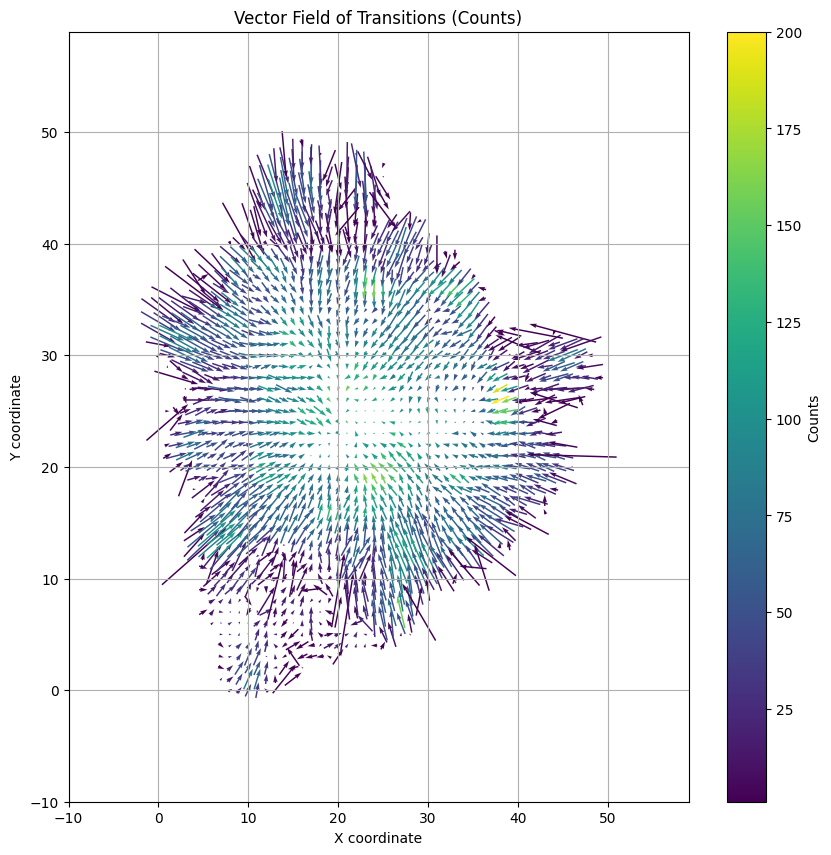

In [44]:
max_vector_length = 10  # You can adjust this to your liking

# Calculate the magnitude of each vector
vector_stats['magnitude'] = np.sqrt(vector_stats['mean_dx']**2 + vector_stats['mean_dy']**2)

# Scaling factor to ensure no vector is longer than 'max_vector_length'
scaling_factor = max_vector_length / vector_stats['magnitude'].max()

# Scale the vectors
vector_stats['scaled_dx'] = vector_stats['mean_dx'] * scaling_factor
vector_stats['scaled_dy'] = vector_stats['mean_dy'] * scaling_factor

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
colors = ax.quiver(vector_stats['from_x'], vector_stats['from_y'], 
                   vector_stats['scaled_dx'], vector_stats['scaled_dy'],
                   vector_stats['count'], angles='xy', scale_units='xy', scale=1, 
                   cmap='viridis', pivot='mid')

# Colorbar
cbar = fig.colorbar(colors, ax=ax)
cbar.set_label('Counts')

# Setting limits for better visualization
ax.set_xlim(vector_stats['from_x'].min() - 10, vector_stats['from_x'].max() + 10)
ax.set_ylim(vector_stats['from_y'].min() - 10, vector_stats['from_y'].max() + 10)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Vector Field of Transitions (Counts)')

# Show the plot
plt.grid(True)
plt.show()

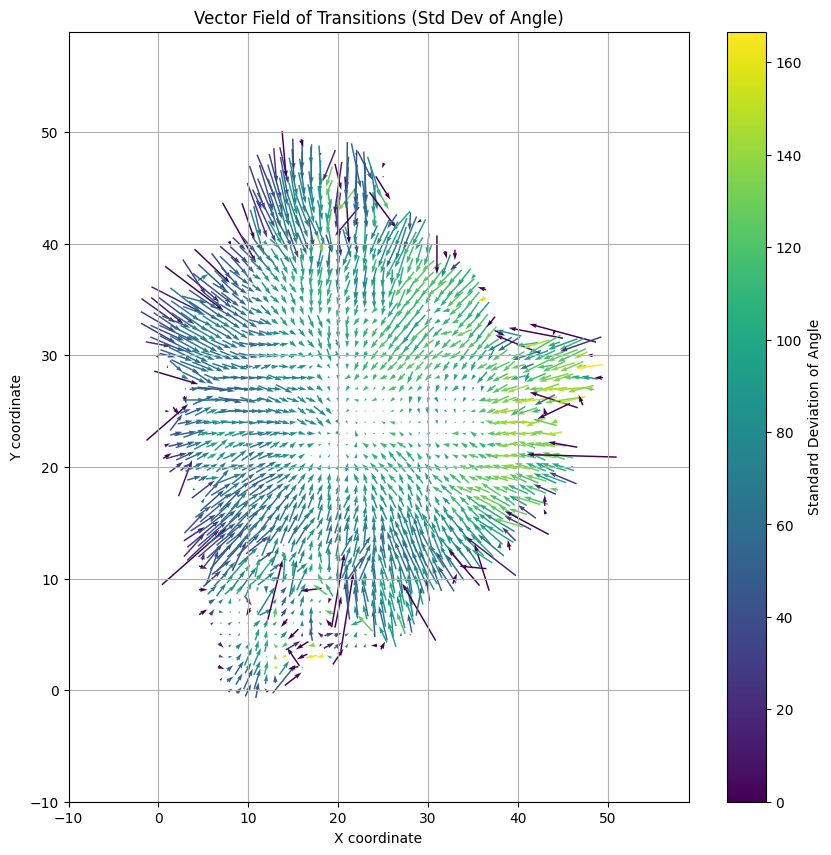

In [45]:
max_vector_length = 10  # You can adjust this to your liking

# Calculate the magnitude of each vector
vector_stats['magnitude'] = np.sqrt(vector_stats['mean_dx']**2 + vector_stats['mean_dy']**2)

# Scaling factor to ensure no vector is longer than 'max_vector_length'
scaling_factor = max_vector_length / vector_stats['magnitude'].max()

# Scale the vectors
vector_stats['scaled_dx'] = vector_stats['mean_dx'] * scaling_factor
vector_stats['scaled_dy'] = vector_stats['mean_dy'] * scaling_factor

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
colors = ax.quiver(vector_stats['from_x'], vector_stats['from_y'], 
                   vector_stats['scaled_dx'], vector_stats['scaled_dy'],
                   vector_stats['std_angle'], angles='xy', scale_units='xy', scale=1, 
                   cmap='viridis', pivot='mid')

# Colorbar
cbar = fig.colorbar(colors, ax=ax)
cbar.set_label('Standard Deviation of Angle')

# Setting limits for better visualization
ax.set_xlim(vector_stats['from_x'].min() - 10, vector_stats['from_x'].max() + 10)
ax.set_ylim(vector_stats['from_y'].min() - 10, vector_stats['from_y'].max() + 10)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Vector Field of Transitions (Std Dev of Angle)')

# Show the plot
plt.grid(True)
plt.show()

In [49]:
%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 966.4 kB/s eta 0:00:00 0:00:01
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 27.8 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.2/39.2 MB 25.8 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


First, we'll try modeling the data with independent Gaussian Processes

In [6]:
tx = transitions[['from_x','from_y','dx','dy']]
tx

,from_x,from_y,dx,dy
0,16.0,16.0,-1.0,-3.0
50405,15.0,13.0,3.0,5.0
50406,18.0,18.0,5.0,7.0
50408,21.0,16.0,16.0,6.0
50409,37.0,22.0,1.0,3.0
...,...,...,...,...
166283,34.0,18.0,-2.0,1.0
166284,32.0,19.0,0.0,1.0
50402,32.0,20.0,-1.0,0.0
50403,31.0,20.0,0.0,0.0


Minor wrangling

In [47]:
tx = transitions[["from_x","from_y","dx","dy","count"]]
tx = tx.loc[tx.index.repeat(tx['count'])].reset_index(drop=True)
tx

,from_x,from_y,dx,dy,count
0,0.0,30.0,2.0,1.0,1
1,0.0,31.0,1.0,0.0,2
2,0.0,31.0,1.0,0.0,2
3,0.0,31.0,1.0,1.0,1
4,0.0,31.0,2.0,1.0,1
...,...,...,...,...,...
153045,48.0,29.0,-4.0,0.0,1
153046,48.0,29.0,-3.0,0.0,1
153047,48.0,29.0,-1.0,1.0,1
153048,48.0,30.0,-3.0,0.0,1


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Assuming 'df_replicated' is your dataframe with the columns 'from_x', 'from_y', 'dx', 'dy'

# Prepare the data
X_train = tx[['from_x', 'from_y']]
y_train_dx = tx['dx']
y_train_dy = tx['dy']

# Define kernels for GPs
kernel_dx = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.5)
kernel_dy = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.5)

# Create Gaussian Process models
gp_dx = GaussianProcessRegressor(kernel=kernel_dx, alpha=0.0)
gp_dy = GaussianProcessRegressor(kernel=kernel_dy, alpha=0.0)

# Fit models
gp_dx.fit(X_train, y_train_dx)
gp_dy.fit(X_train, y_train_dy)

# Predict on the training grid to maintain the structure
y_pred_dx, sigma_dx = gp_dx.predict(X_train, return_std=True)
y_pred_dy, sigma_dy = gp_dy.predict(X_train, return_std=True)

# Composite indicator of variance (sum of standard deviations)
composite_variance = sigma_dx + sigma_dy

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Use quiver to plot vectors and color by composite variance
colors = ax.quiver(tx['from_x'], tx['from_y'], y_pred_dx, y_pred_dy,
                   composite_variance, angles='xy', scale_units='xy', scale=1, cmap='viridis', pivot='mid')

# Add a color bar
cbar = fig.colorbar(colors, ax=ax)
cbar.set_label('Composite Variance (Sum of Std Dev)')

ax.set_xlim(df_replicated['from_x'].min() - 1, df_replicated['from_x'].max() + 1)
ax.set_ylim(df_replicated['from_y'].min() - 1, df_replicated['from_y'].max() + 1)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Vector Field with Variance Indication')

plt.grid(True)
plt.show()



: 

In [9]:
tx["from_x"] = tx['from_x'].astype(int)
tx["from_y"] = tx['from_y'].astype(int)

/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_73606/2067098772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx["from_x"] = tx['from_x'].astype(int)
/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_73606/2067098772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx["from_y"] = tx['from_y'].astype(int)


This didn't work - so, attempting to tile to reduce complexity

In [10]:
import numpy as np

def create_tiles(df, tile_size, overlap=0):
    tiles = []
    step = tile_size - overlap
    for x in range(min(df['from_x']), max(df['from_x']), step):
        for y in range(min(df['from_y']), max(df['from_y']), step):
            # Create a tile
            tile = df[(df['from_x'] >= x) & (df['from_x'] < x + tile_size) &
                      (df['from_y'] >= y) & (df['from_y'] < y + tile_size)]
            if not tile.empty:
                tiles.append(tile)
    return tiles

# Example usage
tile_size = 10  # Define tile size and overlap as needed
tiles = create_tiles(tx, tile_size, overlap=2)


In [17]:
len(tiles)

35

In [18]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def model_tile(tile):
    print(".",end="")
    X_train = tile[['from_x', 'from_y']]
    y_train_dx = tile['dx']
    y_train_dy = tile['dy']

    kernel_dx = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.5)
    kernel_dy = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.5)

    gp_dx = GaussianProcessRegressor(kernel=kernel_dx, alpha=0.0)
    gp_dy = GaussianProcessRegressor(kernel=kernel_dy, alpha=0.0)

    gp_dx.fit(X_train, y_train_dx)
    gp_dy.fit(X_train, y_train_dy)

    return gp_dx, gp_dy

# Model each tile
gps = [model_tile(tile) for tile in tiles]

.

/Users/jeintron/Dropbox/@PROJECTS/BLF/METHOD/3.12.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/jeintron/Dropbox/@PROJECTS/BLF/METHOD/3.12.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


.

/Users/jeintron/Dropbox/@PROJECTS/BLF/METHOD/3.12.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/jeintron/Dropbox/@PROJECTS/BLF/METHOD/3.12.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


.

/Users/jeintron/Dropbox/@PROJECTS/BLF/METHOD/3.12.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/jeintron/Dropbox/@PROJECTS/BLF/METHOD/3.12.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


.

/Users/jeintron/Dropbox/@PROJECTS/BLF/METHOD/3.12.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
